reference: https://redis.io/learn/howtos/solutions/vector/getting-started-vector

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

import timm
import torch
import os
import json
import numpy as np

import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from sklearn.metrics.pairwise import cosine_similarity

/Users/mehrshadshams/anaconda3/envs/deeplearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Sentence Embedding

In [3]:
def generate_sentence_embeddings(sentences):
    model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
    embeddings = model.encode(sentences).astype(np.float32)
    return embeddings

In [4]:
sentences = ["I love redis!"]

embeddings = generate_sentence_embeddings(sentences)
print(embeddings)

[[-9.68780182e-03  5.11356862e-04 -2.83237211e-02 -2.44392529e-02
   6.33870512e-02 -5.17719686e-02 -7.69561715e-03 -1.55224360e-03
  -4.30880338e-02  3.90278660e-02 -7.67854825e-02 -4.37349342e-02
  -2.00277492e-02  4.96894047e-02  2.13521402e-02  3.84606831e-02
   3.90865505e-02  3.34066078e-02 -4.18753782e-03  3.11444793e-02
  -2.09099222e-02  7.67383203e-02 -5.09420075e-02 -2.23097820e-02
   4.06382531e-02 -1.23941135e-02 -1.44757451e-02 -1.01451818e-02
   1.55643960e-02  2.06078701e-02 -4.73228656e-02 -2.81906445e-02
  -6.04404621e-02 -2.83260308e-02 -4.87566814e-02 -4.64696949e-03
  -1.65058225e-02  1.06590176e-02  1.01978034e-02 -5.83192986e-03
   2.06144694e-02 -7.09084347e-02  3.19391787e-02 -4.63668350e-03
  -3.75590473e-02  5.57131972e-03  1.50092831e-02 -2.00494751e-02
   3.83221707e-03  1.50432866e-02  1.11323772e-02  9.28915851e-03
  -1.82590187e-02 -9.07254033e-03  2.10716967e-02  4.64136787e-02
   1.62800830e-02 -4.78226915e-02  1.65191535e-02  1.01058800e-02
   8.37319

In [5]:
embeddings.shape
TEXT_VECTOR_DIM = embeddings.shape[-1]

### Image Embedding

In [6]:
image_file_name = 'dog.jpg'

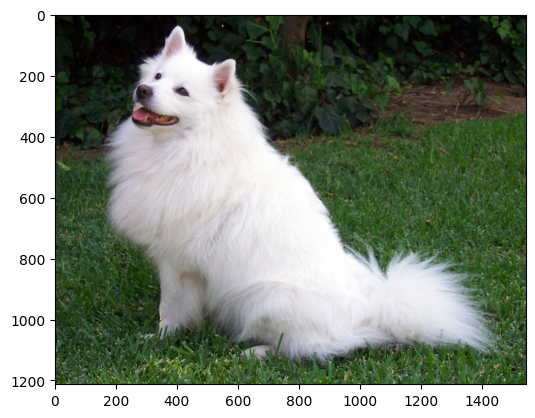

In [7]:
img = Image.open(image_file_name).convert('RGB')
plt.imshow(img)

In [8]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True)
model.eval()

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
     

In [9]:
def decode_image_to_tensor(model, filename):
    # url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
    # urllib.request.urlretrieve(url, filename)
    img = Image.open(filename).convert('RGB')

    config = resolve_data_config({}, model=model)
    transform = create_transform(**config)

    tensor = transform(img).unsqueeze(0) # transform and add batch dimension
    return tensor

In [10]:
def classify_image(model, filename):
    tensor = decode_image_to_tensor(model, filename)
    with torch.no_grad():
        out = model(tensor)
    probabilities = torch.nn.functional.softmax(out[0], dim=0)

    image_net_classes = "imagenet_classes.txt"

    # Get imagenet class mappings
    if not os.path.exists(image_net_classes):
        url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", image_net_classes)
        urllib.request.urlretrieve(url, filename)

    with open(image_net_classes, "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Print top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    # prints class names and probabilities like:
    # [('Samoyed', 0.6425196528434753), ('Pomeranian', 0.04062102362513542), ('keeshond', 0.03186424449086189), ('white wolf', 0.01739676296710968), ('Eskimo dog', 0.011717947199940681)]


In [11]:
classify_image(model, image_file_name)

Samoyed 0.8104050755500793
white wolf 0.021844428032636642
Eskimo dog 0.01768290437757969
Arctic fox 0.009290533140301704
wallaby 0.007410984020680189


In [12]:
def generate_image_embeddings(model, image):
    tensor = decode_image_to_tensor(model, image)
    model.reset_classifier(0)
    with torch.no_grad():
        out = model(tensor)
    return out[0].numpy()

In [13]:
t = decode_image_to_tensor(model, image_file_name)
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=0)
model.eval()
model(t).shape

torch.Size([1, 1280])

In [14]:
embeddings = generate_image_embeddings(model, image_file_name)


In [15]:
embeddings
embeddings.shape
IMAGE_VECTOR_DIM = embeddings.shape[0]

### Redis Vector Support

In [16]:
import redis
import redis.client

from redis.commands.json.path import Path
from redis.commands.search.field import TextField, NumericField, TagField, VectorField
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.query import NumericFilter, Query

In [17]:
redis_client = redis.client.Redis(host='localhost', port=6379)

In [18]:
# create index

schema = (
    TextField('$.productDisplayName', no_stem=True, sortable=True, as_name='productDisplayName'),
    TextField('$.brandName', as_name='brandName'),
    NumericField('$.price', sortable=True, as_name='price'),
    TagField('$.masterCategory', as_name='masterCategory'),
    TagField('$.subCategory', as_name='subCategory'),
    VectorField('$.productDescriptionEmbeddings', algorithm='FLAT', as_name='productDescriptionEmbeddings', attributes={'type':'FLOAT32', 'dim':TEXT_VECTOR_DIM, 'distance_metric':'L2', 'initial_cap':100}),
    TextField('$.productDescription', no_stem=True, sortable=True, as_name='productDescription'),
    TextField('$.imageURL', no_stem=True, as_name='imageURL'),
    VectorField('$.productImageEmbeddings', algorithm='FLAT', as_name='productImageEmbeddings', attributes={'type':'FLOAT32', 'dim':IMAGE_VECTOR_DIM, 'distance_metric':'COSINE', 'initial_cap':100})
)

In [19]:
PRODUCTS_INDEX_KEY = 'idx:products'
rs = redis_client.ft(PRODUCTS_INDEX_KEY)
try:
    # rs.info()
    rs.dropindex(PRODUCTS_INDEX_KEY)
except redis.exceptions.ResponseError as e:
    rs.create_index(schema, definition=IndexDefinition(prefix=['products:'], index_type=IndexType.JSON))

In [20]:
with open('products.json', 'r') as f:
    products = json.load(f)

In [21]:
products

[{'_id': '1',
  'price': 4950,
  'productDisplayName': 'Puma Men Race Black Watch',
  'brandName': 'Puma',
  'ageGroup': 'Adults-Men',
  'gender': 'Men',
  'masterCategory': 'Accessories',
  'subCategory': 'Watches',
  'imageURL': 'images/11002.jpg',
  'productDescription': '<p>This watch from puma comes in a heavy duty design. The asymmetric dial and chunky casing gives this watch a tough appearance perfect for navigating the urban jungle.<br /><strong><br />Dial shape</strong>: Round<br /><strong>Case diameter</strong>: 32 cm<br /><strong>Warranty</strong>: 2 Years<br /><br />Stainless steel case with a fixed bezel for added durability, style and comfort<br />Leather straps with a tang clasp for comfort and style<br />Black dial with cat logo on the 12 hour mark<br />Date aperture at the 3 hour mark<br />Analog time display<br />Solid case back made of stainless steel for enhanced durability<br />Water resistant upto 100 metres</p>'},
 {'_id': '2',
  'price': 5450,
  'productDisplayN

In [22]:
for product in products:
    product_id = product['_id']
    product_desc = product['productDescription']
    product_image = product['imageURL']

    print(f'generating description embeddings for product {product_id}')

    sentence_embedding = generate_sentence_embeddings([product_desc])
    product['productDescriptionEmbeddings'] = sentence_embedding.tolist()[0]

    print(f'generating image embeddings for product {product_id}')
    image_embedding = generate_image_embeddings(model, product_image)
    product['productImageEmbeddings'] = image_embedding.tolist()

    redis_client.json().set(f'products:{product_id}', Path.root_path(), product)
    print(f'product {product_id} added to redis')

generating description embeddings for product 1
generating image embeddings for product 1
product 1 added to redis
generating description embeddings for product 2
generating image embeddings for product 2
product 2 added to redis
generating description embeddings for product 3
generating image embeddings for product 3
product 3 added to redis


In [23]:
p1 = redis_client.json().get('products:1')
p1

{'_id': '1',
 'price': 4950,
 'productDisplayName': 'Puma Men Race Black Watch',
 'brandName': 'Puma',
 'ageGroup': 'Adults-Men',
 'gender': 'Men',
 'masterCategory': 'Accessories',
 'subCategory': 'Watches',
 'imageURL': 'images/11002.jpg',
 'productDescription': '<p>This watch from puma comes in a heavy duty design. The asymmetric dial and chunky casing gives this watch a tough appearance perfect for navigating the urban jungle.<br /><strong><br />Dial shape</strong>: Round<br /><strong>Case diameter</strong>: 32 cm<br /><strong>Warranty</strong>: 2 Years<br /><br />Stainless steel case with a fixed bezel for added durability, style and comfort<br />Leather straps with a tang clasp for comfort and style<br />Black dial with cat logo on the 12 hour mark<br />Date aperture at the 3 hour mark<br />Analog time display<br />Solid case back made of stainless steel for enhanced durability<br />Water resistant upto 100 metres</p>',
 'productDescriptionEmbeddings': [-0.05599648505449295,
  -0

In [24]:
info = redis_client.ft(PRODUCTS_INDEX_KEY).info()
num_docs = info["num_docs"]
indexing_failures = info["hash_indexing_failures"]

print(f"{num_docs} documents indexed with {indexing_failures} failures")

3 documents indexed with 0 failures


In [25]:
query = Query("@brandName:Puma")
res = redis_client.ft("idx:products").search(query).docs

res

[Document {'id': 'products:2', 'payload': None, 'json': '{"_id":"2","price":5450,"productDisplayName":"Puma Men Top Fluctuation Red Black Watches","brandName":"Puma","ageGroup":"Adults-Men","gender":"Men","masterCategory":"Accessories","subCategory":"Watches","imageURL":"images/11001.jpg","productDescription":"<p style=\\"text-align: justify;\\">This watch from puma comes in a clean sleek design. This active watch is perfect for urban wear and can serve you well in the gym or a night of clubbing.<br /><strong><br />Case diameter</strong>: 40 mm&lt;</p>","productDescriptionEmbeddings":[-0.05678950250148773,-0.06482832133769989,-0.002997158095240593,-0.03923296928405762,-0.03967962414026261,0.09491343051195145,-0.015965821221470833,-0.0066384244710206985,0.03323335945606232,-0.0025394398253411055,0.061166055500507355,0.003533038077875972,0.002721721539273858,0.007014281116425991,0.021985087543725967,-0.005971808917820454,0.04857770726084709,0.043551038950681686,-0.06758755445480347,-0.05

### Redis Vector Search (text)

In [26]:
search_text = "Puma watch with cat"
search_text_emb = generate_sentence_embeddings([search_text])

In [27]:
search_bytes = search_text_emb[0].tobytes()

In [28]:
result_count = 3
search_query = f'*=>[KNN {result_count} @productDescriptionEmbeddings $searchBlob AS score]'

query = (
    Query(search_query)\
        .sort_by('score')\
        .return_fields('score', 'brandName', 'price', 'productDisplayName', 'imageURL')\
        .dialect(2)
)

In [29]:
result = redis_client.ft(PRODUCTS_INDEX_KEY).search(query, {'searchBlob': search_bytes})

In [30]:
result.docs

[Document {'id': 'products:1', 'payload': None, 'score': '0.393327951431', 'brandName': 'Puma', 'price': '4950', 'productDisplayName': 'Puma Men Race Black Watch', 'imageURL': 'images/11002.jpg'},
 Document {'id': 'products:2', 'payload': None, 'score': '0.418249428272', 'brandName': 'Puma', 'price': '5450', 'productDisplayName': 'Puma Men Top Fluctuation Red Black Watches', 'imageURL': 'images/11001.jpg'},
 Document {'id': 'products:3', 'payload': None, 'score': '0.879258751869', 'brandName': 'Inkfruit', 'price': '499', 'productDisplayName': 'Inkfruit Women Behind Cream Tshirts', 'imageURL': 'images/11008.jpg'}]

### Redis Vector Search (Image)

In [31]:
result_count = 3
search_query = f'*=>[KNN {result_count} @productImageEmbeddings $searchBlob AS score]'

query = (
    Query(search_query)\
        .sort_by('score')\
        .return_fields('score', 'brandName', 'price', 'productDisplayName', 'imageURL')\
        .dialect(2)
)

In [32]:
dog_emb = generate_image_embeddings(model, 'dog.jpg')
dog2_emb = generate_image_embeddings(model, 'dog2.jpg')

In [33]:
search_bytes = dog_emb.tobytes()

In [34]:
result = redis_client.ft(PRODUCTS_INDEX_KEY).search(query, {'searchBlob': search_bytes})

In [35]:
result.docs

[Document {'id': 'products:1', 'payload': None, 'score': '0.962720215321', 'brandName': 'Puma', 'price': '4950', 'productDisplayName': 'Puma Men Race Black Watch', 'imageURL': 'images/11002.jpg'},
 Document {'id': 'products:2', 'payload': None, 'score': '1.02179646492', 'brandName': 'Puma', 'price': '5450', 'productDisplayName': 'Puma Men Top Fluctuation Red Black Watches', 'imageURL': 'images/11001.jpg'},
 Document {'id': 'products:3', 'payload': None, 'score': '1.07149744034', 'brandName': 'Inkfruit', 'price': '499', 'productDisplayName': 'Inkfruit Women Behind Cream Tshirts', 'imageURL': 'images/11008.jpg'}]

In [36]:
# watch_emb = generate_image_embeddings(model, 'images/11001.jpg')

p1 = redis_client.json().get('products:1')
watch_emb = np.array(p1['productImageEmbeddings'], dtype=np.float32)

In [37]:
cosine_similarity([dog_emb], [watch_emb])

array([[0.03727978]], dtype=float32)

In [38]:
cosine_similarity([dog_emb], [dog2_emb])

array([[0.27295548]], dtype=float32)